In [ ]:
pip install ta==0.4.7

In [40]:
import glob
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt

from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Get CSVs Filename Into a Variable

In [41]:
csv_paths = glob.glob('arb_data/*.csv') # modify to your filepath for data
model_paths = glob.glob('arb_pickles/*.pkl')
len(csv_paths), len(model_paths)

(21, 21)

In [42]:
csv_paths[:]

['arb_data/bitfinex_gemini_bch_btc.csv',
 'arb_data/bitfinex_coinbase_pro_bch_usd.csv',
 'arb_data/gemini_hitbtc_ltc_btc.csv',
 'arb_data/bitfinex_coinbase_pro_ltc_usd.csv',
 'arb_data/gemini_hitbtc_bch_btc.csv',
 'arb_data/coinbase_pro_hitbtc_eth_usdc.csv',
 'arb_data/bitfinex_hitbtc_ltc_btc.csv',
 'arb_data/bitfinex_gemini_ltc_btc.csv',
 'arb_data/bitfinex_hitbtc_eos_usdt.csv',
 'arb_data/coinbase_pro_gemini_ltc_btc.csv',
 'arb_data/bitfinex_coinbase_pro_eth_btc.csv',
 'arb_data/coinbase_pro_hitbtc_bch_btc.csv',
 'arb_data/coinbase_pro_gemini_bch_btc.csv',
 'arb_data/bitfinex_hitbtc_bch_usdt.csv',
 'arb_data/bitfinex_coinbase_pro_etc_usd.csv',
 'arb_data/bitfinex_coinbase_pro_ltc_btc.csv',
 'arb_data/bitfinex_coinbase_pro_bch_btc.csv',
 'arb_data/kraken_gemini_ltc_btc.csv',
 'arb_data/kraken_gemini_bch_btc.csv',
 'arb_data/bitfinex_hitbtc_ltc_usdt.csv',
 'arb_data/bitfinex_hitbtc_eth_btc.csv']

In [43]:
def resample_ohlcv(df, period='5T'):
    """ Changes the time period on cryptocurrency ohlcv data.
        Period is a string denoted by 'time_in_minutesT'(ex: '1T', '5T', '60T')."""

    # Set date as the index. This is needed for the function to run
    df = df.set_index(['date'])

    # Aggregation function
    ohlc_dict = {'open':'first',                                                                                                    
                 'high':'max',                                                                                                       
                 'low':'min',                                                                                                        
                 'close': 'last',                                                                                                    
                 'base_volume': 'sum'}

    # Apply resampling.
    df = df.resample(period, how=ohlc_dict, closed='left', label='left')
    
    return df



# function to handle nans in the data introduced by resampling
def fill_nan(df):
    # forward filling the closing price where there were gaps in ohlcv csv
    df['close'] = df['close'].ffill()
    
    # backfilling the rest of the nans
    df = df.bfill(axis=1)
    
    # returning the revised dataframe
    return df

In [44]:
# function to engineer features that can be engineered pre-merge...
def engineer_features(df, period='5T'):

    # convert unix closing_time to datetime
    df['date'] = pd.to_datetime(df['closing_time'], unit='s')
    
    # time resampling to fill gaps in data
    df = resample_ohlcv(df, period)
    
    # move date off the index
    df = df.reset_index()
    
    # create closing_time
    closing_time = df.date.values
    df.drop(columns='date', inplace=True)
    
    # create feature to indicate where rows were gaps in data
    df['nan_ohlcv'] = df['close'].apply(lambda x: 1 if pd.isnull(x) else 0)
    
    # fill gaps in data
    df = fill_nan(df)

    # adding all the technical analysis features...
    df = add_all_ta_features(df, 'open', 'high', 'low', 'close','base_volume', fillna=True)
    
    # add closing time column
    df['closing_time'] = closing_time
    
    return df

In [45]:
# the following functions are used in engineering features post-merge...
# function to create column showing which exchange has a higher closing price
def get_higher_closing_price(df):
    # i.e., if exchange 1 has the higher closing price...
    if (df['close_exchange_1'] - df['close_exchange_2']) > 0:
        # return exchange 1
        return 1
    # otherwise, if exchange 2 has the higher closing price...
    elif (df['close_exchange_1'] - df['close_exchange_2']) < 0:
        # return exchange 2
        return 2
    # otherwise, i.e., if neither has a higher closing price...
    else:
        # return equivalent
        return 0
# function to create column showing percentage by which higher price is higher
def get_pct_higher(df):
    # i.e., if exchange 1 has a higher closing price than exchange 2...
    if df['higher_closing_price'] == 1:
        # return the percentage by which the exchange 1 closing price is 
        # greater than the exchange 2 closing price
        return ((df['close_exchange_1'] / 
                 df['close_exchange_2'])-1)*100
    # otherwise, if exchange 2 has a higher closing price than exchange 1...
    elif df['higher_closing_price'] == 2:
        # return the percentage by which the exchange 2 closing price is
        # greater than the exchange 1 closing price
        return ((df['close_exchange_2'] / 
                 df['close_exchange_1'])-1)*100
    # otherwise, i.e., if the closing prices are equivalent...
    else:
        # return zero
        return 0
# function to create column showing available arbitrage opportunities
def get_arbitrage_opportunity(df):
    # assuming the total fees are 0.55%, if the higher closing price is less
    # than 0.55% higher than the lower closing price...
    if df['pct_higher'] < .55:
        # return 0, for no arbitrage
        return 0
    # otherwise, if the exchange 1 closing price is more than 0.55% higher
    # than the exchange 2 closing price...
    elif df['higher_closing_price'] == 1:
        # return -1, for arbitrage from exchange 2 to exchange 1
        return -1
    # otherwise, if the exchange 2 closing price is more than 0.55% higher
    # than the exchange 1 closing price...
    elif df['higher_closing_price'] == 2:
        # return 1, for arbitrage from exchange 1 to exchange 2
        return 1
    
# function to create column showing how long arbitrage opportunity has lasted
def get_window_length(df):
    # converting arbitrage_opportunity column to a list...
    target_list = df['arbitrage_opportunity'].to_list()
    # setting initial window length to 5, for 5 minutes; will be updated...
    window_length = 5
    # creating empty list to fill with values and ultimately convert to column
    window_lengths = []
    # for i in the range of the length of the arbitrage_opportunity column...
    for i in range(len(target_list)):
        # if a value in the arbitrage_opportunity column is equal to the
        # previous value in the arbitrage_opportunity column...
        if target_list[i] == target_list[i-1]:
            # increase the window length by five minutes...
            window_length += 5
            # and append that window length to the list.
            window_lengths.append(window_length)
        # otherwise, i.e., if a value in the arbitrage_opportunity column is
        # not equal to the previous value in the arbitrage_opportunity column
        else:
            # reset the window length to five minutes...
            window_length = 5
            # and append that window length to the list
            window_lengths.append(window_length)
    # convert the window lengths list to a column, showing how long arbitrage
    # window / no_arbitrage window has lasted.
    df['window_length'] = window_lengths
    # return the dataframe with the new window length column
    return df
        
def merge_dfs(df1, df2):
    
    print('from merge func:', df1.shape, df2.shape)
    # merging two modified ohlcv dfs on closing time to create arbitrage df
    df = pd.merge(df1, df2, on='closing_time',
                  suffixes=('_exchange_1', '_exchange_2'))
    print('from merge func:', df.shape)
    df['closing_time'] = pd.to_datetime(df['closing_time']) 
    print(type(df.closing_time[0]))
    # Create additional date features.
    df['year'] = df['closing_time'].dt.year
    df['month'] = df['closing_time'].dt.month
    df['day'] = df['closing_time'].dt.day
    
    # getting higher_closing_price feature to create pct_higher feature
    df['higher_closing_price'] = df.apply(get_higher_closing_price, axis=1)
    
    # getting pct_higher feature to create arbitrage_opportunity feature
    df['pct_higher'] = df.apply(get_pct_higher, axis=1)
    
    # getting arbitrage_opportunity feature
    df['arbitrage_opportunity'] = df.apply(get_arbitrage_opportunity, axis=1)
    
    # getting window_length feature
    df = get_window_length(df)
    
    return df

In [46]:
# creating target column...
# 1 = ex1 -> ex2, -1 = ex2 -> ex1, 0 = no arb
# function to get target values; takes df and window length to target
def get_target_value(df, interval=30):
    # i.e., if the coming arbitrage window is as long as the targeted interval
    if df['window_length_shift'] >= interval:
        # then if the coming arbitrage window is for exchange 1 to 2...
        if df['arbitrage_opportunity_shift'] == 1:
            # return 1, which means arbitrage from exchange 1 to 2
            return 1
        # otherwise, if the coming arbitrage window is for exchange 2 to 1...
        elif df['arbitrage_opportunity_shift'] == -1:
            # return -1, which means arbitrage from exchange 2 to 1...
            return -1
        # otherwise, if we are coming up on no arbitrage opportunity...
        elif df['arbitrage_opportunity_shift'] == 0:
            # return 0, which means no arbitrage opportunity
            return 0
    # otherwise, i.e., if the coming window is less than our targeted interval
    else:
        # return 0, which means no arbitrage opportunity
        return 0
    
# function to create target column
def get_target(df, interval=30):
    # used to shift rows; assumes candle length is five minutes, interval is
    # in minutes
    rows_to_shift = int(-1*(interval/5))
    # arbitrage_opportunity feature, shifted by length of targeted interval,
    # minus one to predict ten minutes in advance rather than five
    df['arbitrage_opportunity_shift'] = df['arbitrage_opportunity'].shift(
                                           rows_to_shift - 1)
    # window_length feature, shifted by length of targeted interval, minus one
    # to predict ten minutes in advance rather than five
    df['window_length_shift'] = df['window_length'].shift(rows_to_shift - 1)
    # creating target column; this will indicate if an arbitrage opportunity
    # that lasts as long as the targeted interval is forthcoming
    df['target'] = df.apply(get_target_value, axis=1)
    # dropping rows where target could not be calculated due to shift
    df = df[:rows_to_shift - 1]
    # returning resulting dataframe
    return df

def get_close_shift(df, interval=30):
    rows_to_shift = int(-1*(interval/5))
    df['close_exchange_1_shift'] = df['close_exchange_1'].shift(
        rows_to_shift - 2)
    df['close_exchange_2_shift'] = df['close_exchange_2'].shift(
        rows_to_shift - 2)
    return df

# function to create profit feature
def get_profit(df):
    # if exchange 1 has the higher closing price...
    if df['higher_closing_price'] == 1:
        # see how much money you would make if you bought on exchange 2, sold
        # on exchange 1, and took account of 0.55% fees
        return (((df['close_exchange_1_shift'] / 
                 df['close_exchange_2'])-1)*100)-.55
    # otherwise, if exchange 2 has the higher closing price...
    elif df['higher_closing_price'] == 2:
        # see how much money you would make if you bought on exchange 1, sold
        # on exchange 2, and took account of 0.55% fees
        return (((df['close_exchange_2_shift'] / 
                 df['close_exchange_1'])-1)*100)-.55
    # otherwise, i.e., if the closing prices are the same...
    else:
        # return zero, because in that case you shouldn't make a trade
        return 0

In [47]:
def get_exchange_trading_pair(ex_tp):
    
    if len(ex_tp.split('_')) == 5:
        exchange = ex_tp.split('_')[0] + '_' + ex_tp.split('_')[1]
        trading_pair = ex_tp.split('_')[2] + '_' + ex_tp.split('_')[3]
        
    else:
        exchange = ex_tp.split('_')[0]
        trading_pair = ex_tp.split('_')[1] + '_' + ex_tp.split('_')[2]
        
    return exchange, trading_pair

In [59]:
csv_paths = glob.glob('new_arb_csv/*.csv') # modify to your filepath for data
model_paths = glob.glob('arb_pickles/*.pkl')
len(csv_paths), len(model_paths)

(21, 21)

In [35]:
def arb(csv_paths, model_paths):
    
    df_dict = {}
          
        
    for csv_path in csv_paths:
        csv_name = csv_path.split('/')[1][:-4]
        
        for model_path in model_paths:
            model_name = model_path.split('/')[1][:-4]
            
            if csv_name == model_name:
                
                print("\n \n",csv_name,"==", model_name)

                # read csv
                df = pd.read_csv("new_arb_csv/"+csv_name+".csv", index_col=0)

                # convert str closing_time to datetime
                df['closing_time'] = pd.to_datetime(df['closing_time']) 

                # 70/30 train/test split
                test_train_split_row = round(len(df)*.7)

                # get closing_time for t/t split
                test_train_split_time = df['closing_time'][test_train_split_row]

                # remove 1 week from each end of the t/t datasets to create a 
                # two week gap between the data - prevents data leakage
                train_cutoff_time = test_train_split_time - dt.timedelta(days=7)
                test_cutoff_time = test_train_split_time + dt.timedelta(days=7)
                print('cutoff time:', train_cutoff_time, test_cutoff_time)

                # train and test subsets
                train = df[df['closing_time'] < train_cutoff_time]
                test = df[df['closing_time'] > test_cutoff_time]

                # printing shapes to track progress
                print('train and test shape: ', train.shape, test.shape)

                # specifying features for model to use; not using open, high, or
                # low, which are highly correlated with close and do not improve
                # model performance
                features = ['close_exchange_1','base_volume_exchange_1', 
                            'nan_ohlcv_exchange_1','volume_adi_exchange_1', 'volume_obv_exchange_1',
                            'volume_cmf_exchange_1', 'volume_fi_exchange_1','volume_em_exchange_1', 
                            'volume_vpt_exchange_1','volume_nvi_exchange_1', 'volatility_atr_exchange_1',
                            'volatility_bbhi_exchange_1','volatility_bbli_exchange_1', 
                            'volatility_kchi_exchange_1', 'volatility_kcli_exchange_1',
                            'volatility_dchi_exchange_1','volatility_dcli_exchange_1',
                            'trend_macd_signal_exchange_1', 'trend_macd_diff_exchange_1', 'trend_adx_exchange_1',
                            'trend_adx_pos_exchange_1', 'trend_adx_neg_exchange_1',
                            'trend_vortex_ind_pos_exchange_1', 'trend_vortex_ind_neg_exchange_1', 
                            'trend_vortex_diff_exchange_1', 'trend_trix_exchange_1',
                            'trend_mass_index_exchange_1', 'trend_cci_exchange_1',
                            'trend_dpo_exchange_1', 'trend_kst_sig_exchange_1',
                            'trend_kst_diff_exchange_1', 'trend_aroon_up_exchange_1',
                            'trend_aroon_down_exchange_1',
                            'trend_aroon_ind_exchange_1',
                            'momentum_rsi_exchange_1', 'momentum_mfi_exchange_1',
                            'momentum_tsi_exchange_1', 'momentum_uo_exchange_1',
                            'momentum_stoch_signal_exchange_1',
                            'momentum_wr_exchange_1', 'momentum_ao_exchange_1',
                            'others_dr_exchange_1', 'close_exchange_2',
                            'base_volume_exchange_2', 'nan_ohlcv_exchange_2',
                            'volume_adi_exchange_2', 'volume_obv_exchange_2',
                            'volume_cmf_exchange_2', 'volume_fi_exchange_2',
                            'volume_em_exchange_2', 'volume_vpt_exchange_2',
                            'volume_nvi_exchange_2', 'volatility_atr_exchange_2',
                            'volatility_bbhi_exchange_2', 
                            'volatility_bbli_exchange_2',
                            'volatility_kchi_exchange_2',
                            'volatility_kcli_exchange_2',
                            'volatility_dchi_exchange_2',
                            'volatility_dcli_exchange_2',
                            'trend_macd_signal_exchange_2',
                            'trend_macd_diff_exchange_2', 'trend_adx_exchange_2',
                            'trend_adx_pos_exchange_2', 'trend_adx_neg_exchange_2',
                            'trend_vortex_ind_pos_exchange_2',
                            'trend_vortex_ind_neg_exchange_2',
                            'trend_vortex_diff_exchange_2', 'trend_trix_exchange_2',
                            'trend_mass_index_exchange_2', 'trend_cci_exchange_2',
                            'trend_dpo_exchange_2', 'trend_kst_sig_exchange_2',
                            'trend_kst_diff_exchange_2', 'trend_aroon_up_exchange_2',
                            'trend_aroon_down_exchange_2',
                            'trend_aroon_ind_exchange_2',
                            'momentum_rsi_exchange_2', 'momentum_mfi_exchange_2',
                            'momentum_tsi_exchange_2', 'momentum_uo_exchange_2',
                            'momentum_stoch_signal_exchange_2',
                            'momentum_wr_exchange_2', 'momentum_ao_exchange_2',
                            'others_dr_exchange_2', 'year', 'month', 'day',
                            'higher_closing_price', 'pct_higher', 
                            'arbitrage_opportunity', 'window_length']

                # specifying name of target column
                target = 'target'

                # separating features from target
                ct = test['closing_time']

                X_test = test[features]
                y_test = test[target]
                print('train test shapes:', X_test.shape, y_test.shape)

                model = pickle.load(open(model_path, 'rb'))
                print('model loaded')

                # make predictions
                y_preds = model.predict(X_test)
                print('predictions made!')

                X_test['pred'] = y_preds

                df = X_test
                
                df = pd.concat([ct,df], axis=1)
                
                df['pct_diff'] = (df['close_exchange_1'] - df['close_exchange_2']) / df['close_exchange_1']
                
                df['zero'] = 0
                # 'arb_ex1_ex2' # 1 = ex1 -> ex2, -1 = ex2 -> ex1, 0 = no arb
                df['arb_ex1_ex2'] = df['pred'].apply(lambda x: 1 if x == 1 else np.NaN)
                df['arb_ex2_ex1'] = df['pred'].apply(lambda x: 1 if x == -1 else np.NaN)
                df['arb_ex1_ex2'] = (df['arb_ex1_ex2'] * df['pct_diff'])
                df['arb_ex2_ex1'] = (df['arb_ex2_ex1'] * df['pct_diff'])
                
                
                df_dict[model_name] = df
              
    
    return df_dict

In [36]:
df_dict = arb(csv_paths, model_paths)


 
 bitfinex_coinbase_pro_ltc_usd == bitfinex_coinbase_pro_ltc_usd
cutoff time: 2018-11-10 07:55:00 2018-11-24 07:55:00
train and test shape:  (234762, 147) (99460, 147)
train test shapes: (99460, 91) (99460,)
model loaded
predictions made!

 
 bitfinex_hitbtc_bch_usdt == bitfinex_hitbtc_bch_usdt
cutoff time: 2019-08-27 19:10:00 2019-09-10 19:10:00
train and test shape:  (39564, 147) (15803, 147)
train test shapes: (15803, 91) (15803,)
model loaded
predictions made!

 
 bitfinex_coinbase_pro_etc_usd == bitfinex_coinbase_pro_etc_usd
cutoff time: 2019-06-14 19:20:00 2019-06-28 19:20:00
train and test shape:  (89287, 147) (37113, 147)
train test shapes: (37113, 91) (37113,)
model loaded
predictions made!


In [58]:
import numpy as np
from scipy.signal import savgol_filter

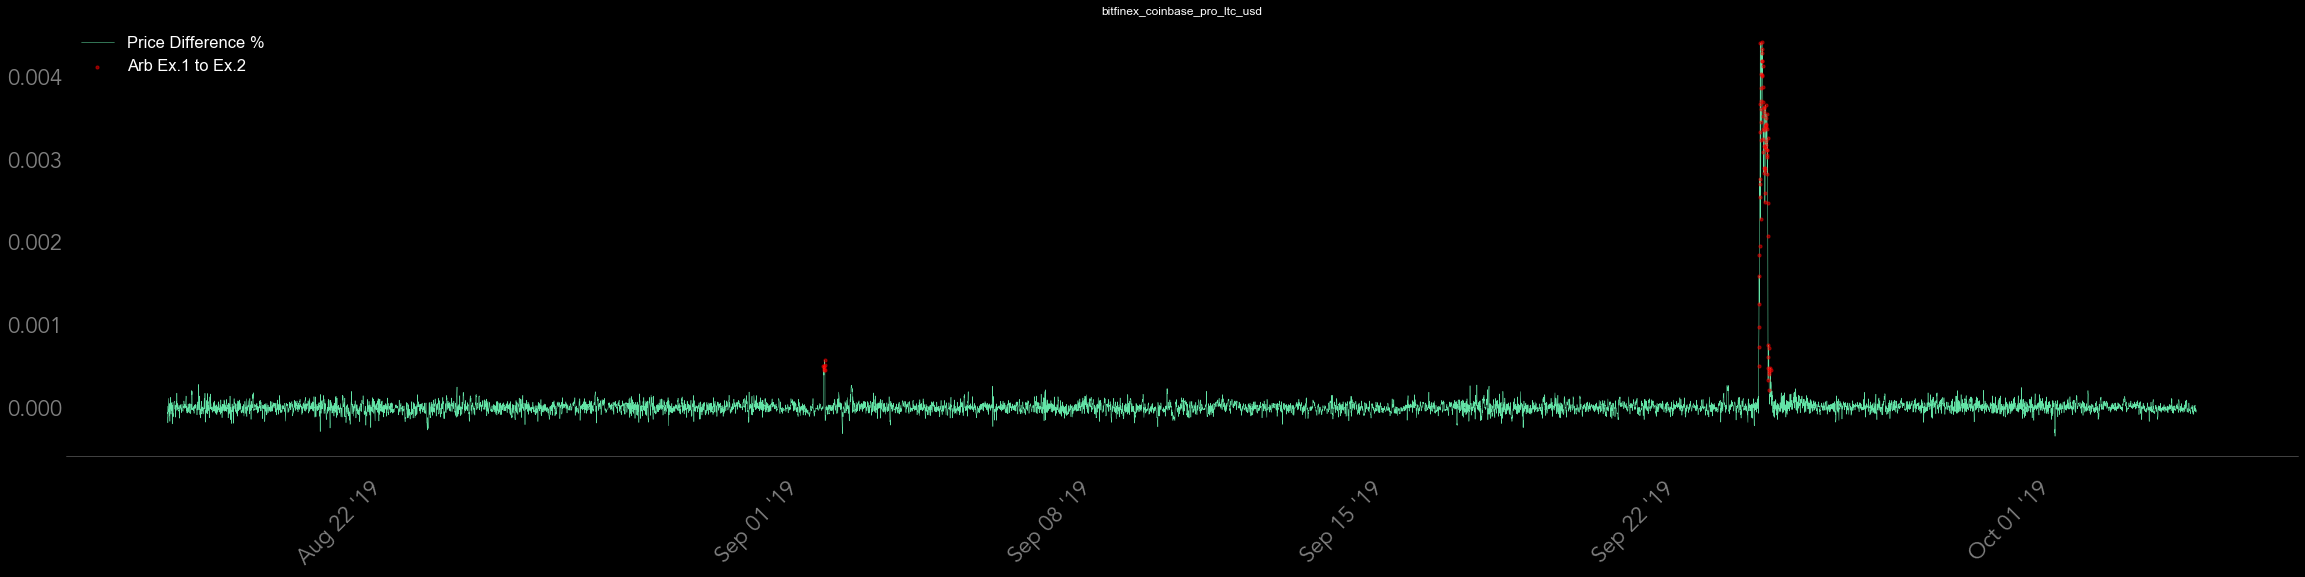

In [85]:
# df_dict['bitfinex_coinbase_pro_ltc_usd'][['closing_time', 'close_exchange_1', 'close_exchange_2', 'pred', 'pct_diff']]
fig, ax = plt.subplots(figsize=(40, 8))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

flatui = ['#63e4a7', '#4eb9ff', '#4bc1f6', '#4fc9e5', '#57d5c7', '#5dddb9', '#63e4a7']

myFmt = mdates.DateFormatter("%b %d '%y    ")

sns.set_palette(flatui)

# Y2 = savgol_filter(df['2_minus_1'], 101, 3)
                   
flatui1 = ['#63e4a7']
sns.set_palette(flatui)
ax1 = sns.lineplot(x='closing_time', y='2_minus_1', data=df[6000:20000], linewidth=.5, label='Price Difference %');

ax3 = sns.regplot(x='closing_time', y='markers', data=df[6000:20000], marker="o", fit_reg=False, scatter_kws={"zorder":10, "color":"red","alpha":.5,"s":10}, label='Arb Ex.1 to Ex.2');


sns.despine(left=True)
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_ylabel('');
ax.set_xlabel('');

plt.setp(ax.get_xticklabels(), rotation=45)

ax.xaxis.set_major_formatter(myFmt)


ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_linewidth(0.5)


for tick in ax.get_xticklabels():
    tick.set_fontname("avenir")
for tick in ax.get_yticklabels():
    tick.set_fontname("avenir")
    
    
lines, labels = ax1.get_legend_handles_labels()
leg = plt.legend(lines , labels , loc='upper left')
leg.get_frame().set_linewidth(0.0)



sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 8})

ax.set_title("bitfinex_coinbase_pro_ltc_usd", fontsize=12);


# Arbitrage Visualization Function 
csv has 3 columns ['closing_time', '2_minus_1', 'pred']


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# looks thru dir for csv
for filename in os.listdir('simple_csvs'):
    if filename.endswith('.csv'):
        
        print(filename)
        
        # create df from csv
        df = pd.read_csv('simple_csvs/' + filename, index_col=0)
        
        # cutting df for smaller df (more recent time)
        df = df[df['closing_time'] >= 1571356800]
        
        # change closetime to datetime format 
        df['closing_time'] = pd.to_datetime(df['closing_time'], unit='s')
        
        print("plotting...")
        
        # creating figure and setting size
        fig, ax = plt.subplots(figsize=(18, 10))
        fig.clf()
        sns.set(style="ticks", context="talk")
        
        # setting dark background
        plt.style.use("dark_background")

        # using these color palette 
        flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
                  '#57d5c7', '#5dddb9', '#63e4a7']
        # seperate df into 6 
        sixth_of_length = (len(df)//6)
        
        # create 6 lineplots to create a gradient look 
        sns.set_palette(flatui)
        ax = sns.lineplot(x='closing_time', y='2_minus_1_over_1',
                          data=df[:sixth_of_length])
        
        for i in range(1, 6):
            sns.set_palette(flatui)
            if i != 3:
                ax = sns.lineplot(x='closing_time', y='2_minus_1_over_1',
                                  data=df[(sixth_of_length*i):
                                          (sixth_of_length*(i+1))])
            else:
                ax = sns.lineplot(x='closing_time', y='2_minus_1_over_1',
                                  data=df[(sixth_of_length*i):
                                          (sixth_of_length*(i+1))],
                                  label='Percentage Price Difference')
        
        # creating 2 df seperated by prediction
        df_1_to_2 = df[df['pred'] == 1]
        df_2_to_1 = df[df['pred'] == -1]
        
        # creating 2 scatter plot with new df
        # arbitrage indicator
        dots_1_to_2 = sns.scatterplot(x='closing_time', y='2_minus_1_over_1',
                                      data=df_1_to_2, color='indigo',
                                      zorder=10, label='Arbitrage from '
                                      'Exchange 1 to 2')
        dots_2_to_1 = sns.scatterplot(x='closing_time', y='2_minus_1_over_1',
                                      data=df_2_to_1, color='violet',
                                      zorder=10, label='Arbitrage from '
                                      'Exchange 2 to 1')
        
        sns.despine(left=True, right=True, top=True)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # setting y tick labels 
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

        # get rid of '-' on tick label
        ax.tick_params(axis=u'both', which=u'both',length=0)

        # change x and y tick color grey
        ax.tick_params(axis='x', colors='grey')
        ax.tick_params(axis='y', colors='grey')
        
        # set bottom spine grey and change linewidth
        ax.spines['bottom'].set_color('grey')
        ax.spines['bottom'].set_linewidth(0.5)

        # change font style 
        for tick in ax.get_xticklabels():
            tick.set_fontname("avenir")
        for tick in ax.get_yticklabels():
            tick.set_fontname("avenir")
            
        # format datetime for x-axis tick label
        myFmt = mdates.DateFormatter("%b. %d    ")
        ax.xaxis.set_major_formatter(myFmt)
        
        # rotate x-tick labels at a 45 degree angle
        plt.setp(ax.get_xticklabels(), rotation=45)
        
        # creates Legend 
        lines, labels = ax.get_legend_handles_labels()
        leg = plt.legend(lines, labels, loc='upper left')
        leg.get_frame().set_linewidth(0.0)
        
        currency_pairs = {'bch_btc': 'bch/btc'.upper(),
                          'bch_usd': 'bch/usd'.upper(),
                          'bch_usdt': 'bch/usdt'.upper(),
                          'eos_usdt': 'eos/usdt'.upper(), 
                          'etc_usd': 'etc/usd'.upper(),
                          'eth_btc': 'eth/btc'.upper(),
                          'eth_usdc': 'eth/usdc'.upper(),
                          'ltc_btc': 'ltc/btc'.upper(), 
                          'ltc_usd': 'ltc/usd'.upper(),
                          'ltc_usdt': 'ltc/usdt'.upper()}
        
        exchange_pairs = {'bitfinex_coinbase_pro_': 'Bitfinex/Coinbase Pro ',
                          'bitfinex_gemini_': 'Bitfinex/Gemini ',
                          'bitfinex_hitbtc_': 'Bitfinex/Hitbtc ',
                          'coinbase_pro_gemini_': 'Coinbase Pro/Gemini ',
                          'coinbase_pro_hitbtc_': 'Coinbase Pro/Hitbtc ',
                          'gemini_hitbtc_': 'Gemini/Hitbtc ', 
                          'kraken_gemini_': 'Kraken/Gemini '}
        
        name = filename
        for currency_pair in currency_pairs:
            if currency_pair in name:
                name = name.replace(currency_pair,
                                    currency_pairs[currency_pair])
        

        for exchange_pair in exchange_pairs:
            if exchange_pair in name:
                name = name.replace(exchange_pair,
                                    exchange_pairs[exchange_pair])
        
        # set titles
        ax.set_title(name.replace('.csv', ''), fontsize=12);
        
        # save figures into png folder
        fig = ax.get_figure()
        fig.savefig('pngs/' + filename.replace('.csv', '.png'))
        
        print("done!")